Necessary imports:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

Implemented gradients:

In [13]:
def hsv2rgb(h, s, v): # supporting function converting hsv to rgb
    hsv = np.array([h, s, v])
    rgb = colors.hsv_to_rgb(hsv)
    r, g, b = rgb[0], rgb[1], rgb[2]
    return (r, g, b)

# gradients

def gradient_rgb_bw(v):
    return (v, v, v)


def gradient_rgb_gbr(v):
    red = 0
    green = 0
    blue = 0

    if v <= 1/2:
        green = 1 - (v * 2)
        blue = 2 * v
    else:
        red = (v * 2) - 1
        blue = 2 - (v * 2)

    return (red, green, blue)


def gradient_rgb_gbr_full(v):
    red = 0
    green = 0
    blue = 0

    if v <= 0.25:
        green = 1
        blue = v * 4
    elif v <= 0.5:
        green = 2 - (v * 4)
        blue = 1
    elif v <= 0.75:
        red = (v * 4) - 2
        blue = 1
    else:
        red = 1
        blue = 4 - (v * 4)

    return (red, green, blue)


def gradient_rgb_wb_custom(v):
    red = 1
    green = 1
    blue = 1

    if v <= 1/7:
        green = 1 - (v * 7)
    elif v <= 2/7:
        red = 2 - (v * 7)
        green = 0
    elif v <= 3/7:
        red = 0
        green = (v * 7) - 2
    elif v <= 4/7:
        red = 0
        blue = 4 - (v * 7)
    elif v <= 5/7:
        red = (v * 7) - 4
        blue = 0
    elif v <= 6/7:
        green = 6 - (v * 7)
        blue = 0
    else:
        red = 7 - (v * 7)
        green = 0
        blue = 0

    return (red, green, blue)


def gradient_hsv_bw(v):
    return hsv2rgb(0, 0, v)


def gradient_hsv_gbr(v):
    return hsv2rgb(1/3 + (v * 2)/3, 1, 1)


def gradient_hsv_unknown(v):
    return hsv2rgb(1/3 - v/3, 1/2, 1)


def gradient_hsv_custom(v):
    return hsv2rgb(v, 1 - v, 1)

Supporting functions used for drawing the plot:

In [14]:
def get_name(gradient):
    return gradient.__name__.replace('gradient_', '').replace('_', '-').upper()

def draw_gradients(gradients, names):
    # set the font
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    # set other paramethers
    plt.rc('legend', fontsize=10)

    column_width_pt = 400 # Show in latex using \the\linewidth
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch

    fig, axes = plt.subplots(nrows=len(gradients), sharex=True, figsize=(size, 0.75 * size))
    fig.subplots_adjust(top=1.00, bottom=0.05, left=0.25, right=0.95)


    for ax, gradient, name in zip(axes, gradients, names):
        # Create image with two lines and draw gradient on it
        img = np.zeros((2, 1024, 3))
        for i, v in enumerate(np.linspace(0, 1, 1024)):
            img[:, i] = gradient(v)

        im = ax.imshow(img, aspect='auto')
        im.set_extent([0, 1, 0, 1])
        ax.yaxis.set_visible(False)

        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.25
        y_text = pos[1] + pos[3] / 2.
        fig.text(x_text, y_text, name, va='center', ha='left', fontsize=10)

    fig.savefig('gradients.pdf')

Main function:

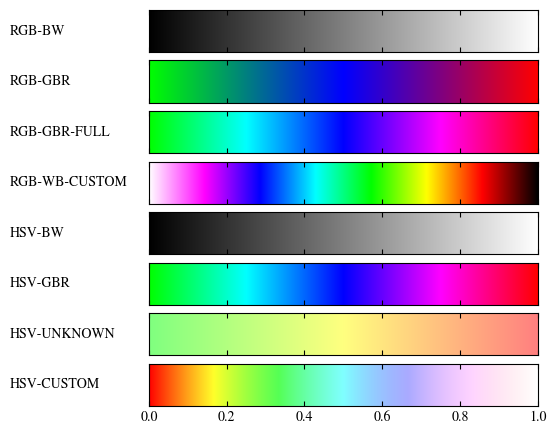

In [15]:
gradients = (gradient_rgb_bw, gradient_rgb_gbr, gradient_rgb_gbr_full, gradient_rgb_wb_custom,
                 gradient_hsv_bw, gradient_hsv_gbr, gradient_hsv_unknown, gradient_hsv_custom)

draw_gradients(gradients, [get_name(g) for g in gradients])

Map gradient:

In [16]:
# calculate the gradient for each pixel individually
def map_gradient(value, angle):
     hue = (1/3 - ((value - 43.252) / (153.833 - 43.252) / 3))
     saturation = (np.clip(1 - ((angle - 0.52) / (2.778 - 0.52) - 0.4) * (1/0.6), 0, 1))
     brightness = np.clip((np.log(angle) + 0.654) / (1.022 + 0.654) * (1/0.7), 0, 1)

     return hsv2rgb(hue, saturation, brightness)


# calculate the gradient for the entire data
def compound_map_gradient(values, angles):
     min_value = np.min(values) # 43.2528741577922
     max_value = np.max(values) # 153.832040129247
     # normalize to get values between 0 and 1
     normalized_values = (values - min_value) / (max_value - min_value) 
     # calculate hue based on normalized values
     hue = 1/3 - (normalized_values / 3)

     min_angle = np.min(angles) # 0.5201196094972295
     max_angle = np.max(angles) # 2.7774647881769297
     # normalize to get values between 0 and 1
     normalized_angles = (angles - min_angle) / (max_angle - min_angle)
     # calculate saturation based on normalized angles
     saturation = np.clip(1 - (normalized_angles - 0.4) * (1/0.6), 0, 1)

     # transform min and max values
     log_min = np.log(min_angle) # -0.6536964755929061
     log_max = np.log(max_angle) # 1.0215385649272297
     # calculate log values for the angles (BUG: angle == 0)
     log_angles = np.log(angles)
     # normalize to get values between 0 and 1
     normalized_log_angles = (log_angles - log_min) / (log_max - log_min)
     # calculate brightness based on normalized log angles
     brightness = np.clip(normalized_log_angles * (1/0.7), 0, 1)

     return colors.hsv_to_rgb(np.stack((hue, saturation, brightness), axis=-1))


Reading the data:

In [17]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        # read the first line
        line = file.readline()  
        values = line.strip().split()
        params = np.array([np.int32(values[0]), np.int32(values[1]), np.float64(values[2]) / 1000], dtype=object)

        # read the rest of the file
        data = np.loadtxt(file)

        return (data, params)
    

Function for drawing the map using matplotlib:

In [18]:
def draw_map(data, angles, params):
    # set the font
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['font.size'] = 10
    # set the rest of the paramethers
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.right'] = True
    plt.rcParams['ytick.left'] = True
    
    fig, ax = plt.subplots(figsize=(4, 4))


    # NOTE calculate the image using the map_gradient
    
    # create a matrix holding the rgb values of the map points
    img = np.empty((params[0], params[1], 3))
    for (i, j), v in np.ndenumerate(data):
        img[i, j] = map_gradient(v, angles[i, j])

    # convert to image and set the axes's range
    im = ax.imshow(img, aspect='auto')
    im.set_extent([0, params[0] - 1, params[1] - 1, 0])


    # NOTE calculate the image using the compound_map_gradient
    
    # img = compound_map_gradient(data, angles)
    # im = ax.imshow(img, aspect='auto')
    # im.set_extent([0, params[0] - 1, params[1] - 1, 0])

    fig.savefig('map.pdf')
    

Function for calculating normal vectors to the plane formed by a point and its two neighboring points:

In [19]:
def calculate_normals(data, params):
    normal_vectors = np.empty((params[0], params[1], 3))
    dist = params[2]

    # calculate normals for the main grid, excluding the last row and column
    x_diffs = data[1:, :-1] - data[:-1, :-1]
    y_diffs = data[:-1, 1:] - data[:-1, :-1]
    vec1 = np.stack((dist * np.ones_like(y_diffs), 
                     np.zeros_like(y_diffs), 
                     y_diffs), axis=-1)
    vec2 = np.stack((np.zeros_like(x_diffs), 
                     dist * np.ones_like(x_diffs), 
                     x_diffs), axis=-1)
    normal_vectors[:-1, :-1] = np.cross(vec1, vec2)

    # calculate normals for the last row, excluding the last value
    x = params[0] - 1
    x_diffs = data[x - 1, :-1] - data[x, :-1]
    y_diffs = data[x, 1:] - data[x, :-1]
    vec1 = np.stack((np.zeros_like(x_diffs), 
                     -dist * np.ones_like(x_diffs), 
                     x_diffs), axis=-1)
    vec2 = np.stack((dist * np.ones_like(y_diffs), 
                     np.zeros_like(y_diffs), 
                     y_diffs), axis=-1)
    normal_vectors[x, :-1] = np.cross(vec1, vec2)

    # calculate normals for the last column, excluding the last value
    y = params[1] - 1
    x_diffs = data[1:, y] - data[:-1, y] 
    y_diffs = data[:-1, y - 1] - data[:-1, y]
    vec1 = np.stack((np.zeros_like(x_diffs), 
                     dist * np.ones_like(x_diffs), 
                     x_diffs), axis=-1)
    vec2 = np.stack((-dist * np.ones_like(y_diffs), 
                     np.zeros_like(y_diffs), 
                     y_diffs), axis=-1)
    normal_vectors[:-1, y] = np.cross(vec1, vec2)

    # calculate the normal for the bottom-right value
    v = data[x, y]
    vec1 = np.array([-dist, 0, data[x, y - 1] - v])
    vec2 = np.array([0, -dist, data[x - 1, y] - v])
    normal_vectors[x, y] = np.cross(vec1, vec2)

    return normal_vectors


Function used to calculate the angle between the sun's vector, and the normal vector of each point:

In [20]:
def calculate_angles(data, normal_vectors, params, sun):
    angles = np.empty((params[0], params[1]))
    dist = params[2]

    # set the world positions for each point
    x_coords, y_coords = np.meshgrid(dist * np.arange(params[0]), 
                                     dist * np.arange(params[1]), indexing='ij')
    z_coords = data

    # calculate direction vectors from the sun to each point
    dir_vec = np.stack((x_coords - sun[0], 
                        y_coords - sun[1], 
                        z_coords - sun[2]), axis=-1)

    # calculate the dot products between direction vectors and normal vectors
    dot_products = np.sum(dir_vec * normal_vectors, axis=-1)

    # calculate norms for direction vectors and normal vectors
    dir_vec_norms = np.linalg.norm(dir_vec, axis=-1)
    normal_vec_norms = np.linalg.norm(normal_vectors, axis=-1)

    # calculate cosines and clamp the values
    angle_cosines = np.clip(dot_products / (dir_vec_norms * normal_vec_norms), -1, 1)

    # calculate angles
    angles = np.arccos(angle_cosines)

    return angles


Main function:

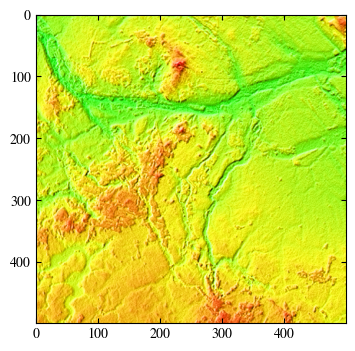

In [21]:
data, params = read_file('data/big.dem')
dist = params[2]

# define sun's position
sun = (-150 * dist, -100 * dist, 150)
    
normal_vectors = calculate_normals(data, params)

angles = calculate_angles(data, normal_vectors, params, sun)

draw_map(data, angles, params)
    